# <span style="color:blue"> Esercitazione 8 - Titolo </span>

## <span style="color:blue"> Indice</span>

- [Esercizio 8.1 - Variational Monte Carlo con algoritmo di Metropolis](#Esercizio8.1)

- [Esercizio 8.2 - Ottimizzazione di parametri mediante Simulated Annealing](#Esercizio8.2)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

## <span id="Esercizio8.1" style="color:blue">  Esercizio 8.1 - Variational Monte Carlo con algoritmo di Metropolis </span>[^](#toc)

### Descrizione

In questo esercizio si applica il metodo del Variational Monte Carlo (VMC) per stimare l’energia dello stato fondamentale di una particella quantistica in una dimensione soggetta al potenziale
$$V(x) = x^4 - \frac{5}{2}x^2$$
Il principio variazionale afferma che, per una qualunque funzione d’onda di prova $\Psi_T(x)$, il valore di aspettazione dell’Hamiltoniana fornisce un limite superiore all’energia dello stato fondamentale $E_0$:
$$
\langle \hat H \rangle_T =
\frac{\int dx \, \Psi_T^*(x) \hat H \Psi_T(x)}
{\int dx \, |\Psi_T(x)|^2}
\ge E_0. 
$$

Si sceglie quindi un’ansatz variazionale dipendente da un numero finito di parametri e si minimizza $\langle \hat H \rangle_T$ rispetto a tali parametri. In questo caso, si utilizza la funzione di prova
$$
\Psi_T^{\mu,\sigma}(x) \propto
e^{-\frac{(x-\mu)^2}{2\sigma^2}}
+
e^{-\frac{(x+\mu)^2}{2\sigma^2}},
$$
che dipende dai due parametri, $\mu$ e $\sigma$. Lo spazio dei parametri è quindi un sottoinsieme di $\mathbb{R}^2$.

L'integrale è riscritto nella forma
$$
\langle \hat H \rangle_T =
\int dx \, \rho(x)\,
\frac{\hat H \Psi_T(x)}{\Psi_T(x)},
\qquad
\rho(x) =
\frac{|\Psi_T(x)|^2}
{\int dx \, |\Psi_T(x)|^2}.
$$
ed è calcolato mediante la tecnica dell'importance sampling:
- si campiona la densità di probabilità $\rho(x)$ con l’algoritmo di Metropolis (con proposta uniforme). Si noti come, utilizzando tale algoritmo, non sia necessario conoscere la costante di normalizzazione, e quindi sia sufficiente campionare $|\Psi_T^{\mu,\sigma}(x)|^2$;
- si calcola il valor medio della restante parte della funzione integranda, tramite la tecnica del data blocking.

_Nota_: il calcolo è stato eseguito in unità ridotte ($\hbar = 1$, $m = 1$). In questo sistema, il calcolo del termine cinetico dell'hamiltoniana è
$$
\frac{
-\frac{1}{2}\frac{\partial^2}{\partial x^2}\Psi_T(x)
}{
\Psi_T(x)
}.
$$

Per maggiori dettagli sul funzionamento dell'algoritmo di Metropolis, si rimanda all'_Esercizio 5.1_.

### Calcolo e risultati

Si è scelto di calcolare $\langle \hat H \rangle_T$ per $(\mu,\sigma)=(1,0.5)$. 

Per la preparazione dell’algoritmo di Metropolis si è proceduto nel seguente modo:
- La nuova posizione viene proposta campionando una distribuzione uniforme centrata nel punto corrente, entro un intervallo di semi-ampiezza $\delta = 1.2$. Con questa scelta si è ottenuto un rate di accettazione pari al $51$%.
- Prima di iniziare il calcolo dell'integrale, è stata condotta l'equilibrazione della sequenza: sono sufficienti $1000$ passi di Metropolis. Il calcolo è stato eseguito partendo quindi dall'ultima posizione salvata per la simulazione di equilibrazione.

Sono stati scelti $M=10^6$ step Monte Carlo e $N=10^3$ blocchi. Ogni blocco contiene quindi $L=10^3$ dati.

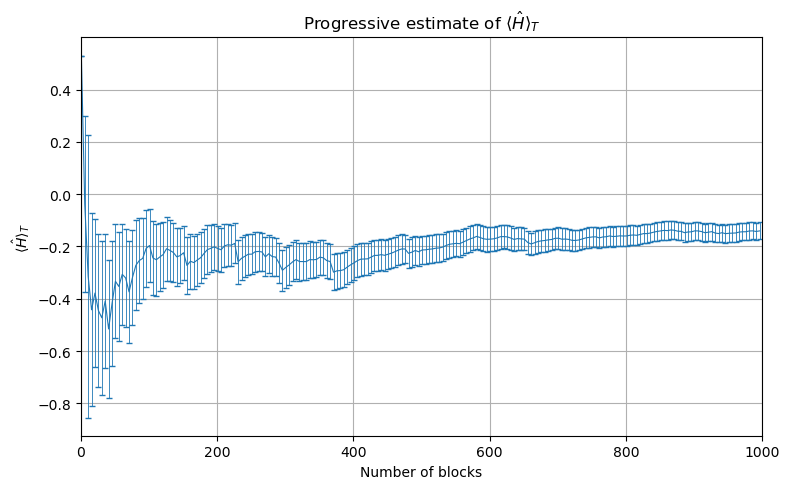

In [93]:
base_path="../Es08/Output/"
# Load progressive averages and errors
Block,HMeanProg,HStDevProg=np.loadtxt(base_path+"energy_08_01.dat",usecols=(0,2,3),unpack=True)

k=5
plt.figure(figsize=(8,5))
plt.errorbar(Block[::k],HMeanProg[::k],yerr=HStDevProg[::k],fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
plt.title(r'Progressive estimate of $\langle \hat{H} \rangle_T$')
plt.xlabel('Number of blocks')
plt.ylabel(r'$\langle \hat{H} \rangle_T$')
plt.xlim(0,Block[-1])
plt.grid(True)
plt.tight_layout()
plt.show()

Il risultato finale del calcolo è

In [95]:
print(f"<H>={HMeanProg[-1]:.3f}±{HStDevProg[-1]:.3f}")

<H>=-0.139±0.032


## <span id="Esercizio8.2" style="color:blue">  Esercizio 8.2 - Ottimizzazione di parametri mediante Simulated Annealing </span>[^](#toc)

### Descrizione

In questo esercizio si affronta il problema dell’ottimizzazione variazionale dei parametri $\mu$ e $\sigma$ che minimizzano l’energia
$$
\langle \hat H \rangle_T=\langle \hat H \rangle_T(\mu,\sigma).
$$
Essa, calcolata tramite Variational Monte Carlo, viene trattata come una funzione costo in uno spazio dei parametri bidimensionale $(\mu,\sigma)\in\mathbb{R}^2$.

L'ottimizzazione, che consiste nella ricerca del minimo, è stata realizzando implementando un algoritmo di _Simulated Annealing_ (SA).
I parametri variazionali vengono considerati come variabili dinamiche e aggiornati tramite una dinamica di tipo Metropolis nello spazio dei parametri.

Si introduce una temperatura fittizia $T$ (o, equivalentemente, $\beta = 1/T$) che controlla la probabilità di accettazione delle variazioni dei parametri.
Per una proposta $(\mu,\sigma) \rightarrow (\mu',\sigma')$ la probabilità di accettazione è la stessa dell'algoritmo di Metropolis:
$$
\alpha = \min \left[ 1, \exp\left(\beta \left( H_{\text{old}} - H_{\text{new}} \right) \right) \right],
$$
dove $H_{\text{old}}$ e $H_{\text{new}}$ sono le stime variazionali dell’energia, corrente e proposta.

Il processo di _annealing_ consiste nell’aumentare progressivamente $\beta$ (ovvero ridurre la temperatura del sistema) per favorire la convergenza verso una configurazione a energia minima. Al termine dell’algoritmo si ottengono i valori ottimali $(\mu_{\text{best}},\sigma_{\text{best}})$ che minimizzano l’energia variazionale.

### Calcolo e risultati

- Per l’algoritmo di Simulated Annealing si è scelta una temperatura iniziale $T=1$, corrispondente a $\beta=1$.
- La crescita progressiva di $\beta$ è stata implementata in $50$ passi di ampiezza $\delta_{\beta}=1$. Per ogni valore di $\beta$ sono stati eseguiti $50$ passi di ottimizzazione. Ad ogni passo
    - vengono proposte piccole variazioni dei parametri variazionali $\mu$ e $\sigma$: si campionando due distribuzioni uniformi centrate rispettivamente nei valori correnti di $\mu$ e $\sigma$, entro intervalli di semi-ampiezza $\delta_{\mu}$ e $\delta_{\sigma}$, scelti pari a $0.5$
    - la coppia campionata $(\mu',\sigma')$ è accettata con probabilità $\alpha$, mostrata in precedenza. In questo calcolo, ogni valore di energia è stato ricavato con $M=10^4$ step e $N=100$ blocchi. 
- Il processo viene arrestato quando l’ampiezza relativa delle variazioni dei parametri $2\delta_{\mu}/\beta=2\delta_{\sigma}/\beta$, diventa confrontabile con la precisione (relativa) desiderata sui parametri, fissata nel codice a $0.01$.

Alla fine del processo, in cui si è giunti a $\beta=99$, sono stati ottenuti i seguenti risultati:

In [149]:
with open("../Es08/Output/annealing_final.dat", "r") as f:
    print(f.read())

Optimization results:
H = -0.439271
mu = -0.860813
sigma = 0.582034



Di seguito si mostra l’andamento dell’energia variazionale in funzione di $\beta$. Per ogni valore di $\beta$ è stato riportato l’ultimo valore di $\langle \hat{H} \rangle_T$ ottenuto dopo i $50$ passi di ottimizzazione, in modo da evidenziare l’effettiva evoluzione del minimo energetico durante il processo di annealing.

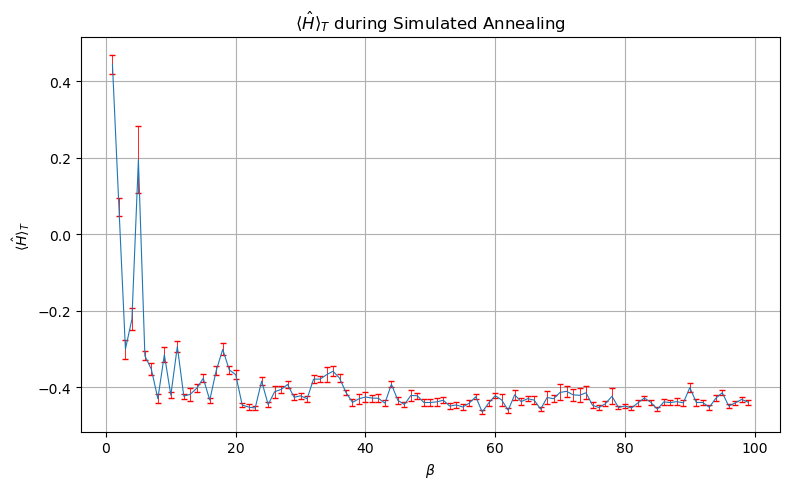

In [188]:
base_path="../Es08/Output/"
# Load annealing data
beta,mu,sigma,H,Herr,acc=np.loadtxt(base_path+"annealing.dat",usecols=(0,1,2,3,4,5),unpack=True)
k=50
plt.figure(figsize=(8,5))
plt.errorbar(beta[k-1::k],H[k-1::k],yerr=Herr[k-1::k],fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2,ecolor='red')
plt.title(r'$\langle \hat{H} \rangle_T$ during Simulated Annealing')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle \hat{H} \rangle_T$')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.show()


Di seguito si mostra la traiettoria dei parametri variazionali $(\mu,\sigma)$ nel piano dei parametri durante il processo di Simulated Annealing. Il punto iniziale corrisponde alla configurazione di partenza $(\mu,\sigma)=(1,0.5)$, mentre il punto finale rappresenta la configurazione ottimizzata.

Si osserva come i parametri evolvano progressivamente verso una regione stabile dello spazio variazionale, in prossimità del minimo dell'energia.

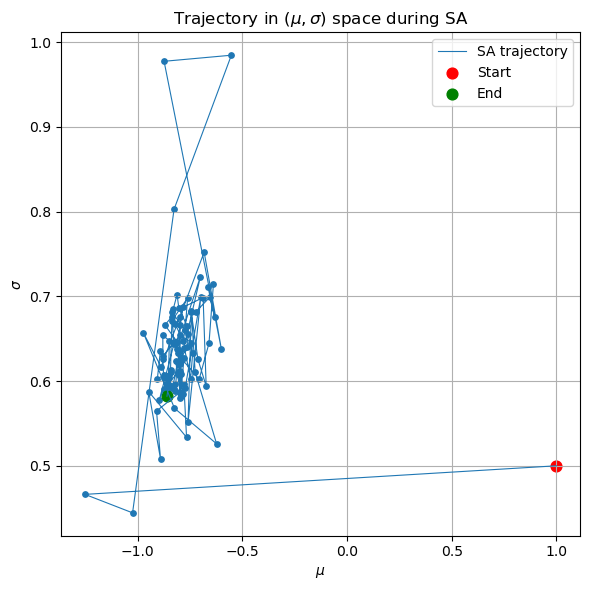

In [190]:
# Load annealing data
k=50
mu_k=np.insert(mu[k-1::k],0,1.0)
sigma_k=np.insert(sigma[k-1::k],0,0.5)
plt.figure(figsize=(6,6))
plt.plot(mu_k,sigma_k,'-',linewidth=0.8,label='SA trajectory')
plt.scatter(mu_k,sigma_k,s=15)
plt.scatter(mu_k[0],sigma_k[0],color='red',s=60,label='Start')
plt.scatter(mu_k[-1],sigma_k[-1],color='green',s=60,label='End')
plt.title(r'Trajectory in $(\mu,\sigma)$ space during SA')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

è stata eseguita una simulazione di Variational Monte Carlo con $(\mu,\sigma)=(\mu_{\text{best}},\sigma_{\text{best}})$ per ottenere una stima più precisa dell’integrale. Sono stati utilizzati $M=10^6$ step e $N=10^3$ blocchi, dopo aver condotto l'equilibrazione. Di seguito si riporta l’andamento della media progressiva dell’energia e della relativa incertezza statistica in funzione del numero di blocchi.

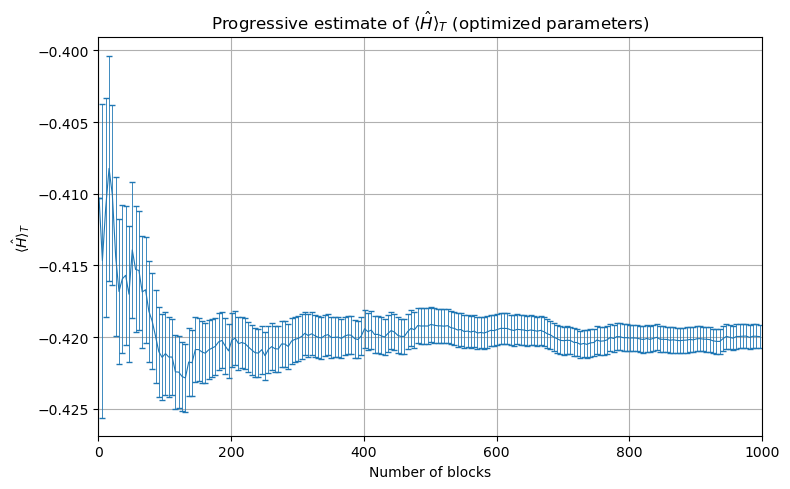

In [195]:
# Load progressive averages and errors
Block,HMeanProg,HStDevProg=np.loadtxt(base_path+"energy.dat",usecols=(0,2,3),unpack=True)
k=5
plt.figure(figsize=(8,5))
plt.errorbar(Block[::k],HMeanProg[::k],yerr=HStDevProg[::k],fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
plt.title(r'Progressive estimate of $\langle \hat{H} \rangle_T$ (optimized parameters)')
plt.xlabel('Number of blocks')
plt.ylabel(r'$\langle \hat{H} \rangle_T$')
plt.xlim(0,Block[-1])
plt.grid(True)
plt.tight_layout()
plt.show()

Il risultato finale del calcolo è

In [202]:
print(f"<H>={HMeanProg[-1]:.5f}±{HStDevProg[-1]:.5f}")

<H>=-0.41993±0.00082


### Istogramma della distribuzione campionata

Si riporta l’istogramma delle posizioni campionate con l’algoritmo di Metropolis utilizzando i parametri ottimizzati $(\mu_{\text{best}},\sigma_{\text{best}})$. L’istogramma, opportunamente normalizzato, fornisce una stima numerica della densità di probabilità $\rho(x)$ definita nel paragrafo dell'_Esercizio 8.1_.

Tale distribuzione viene confrontata con la curva analitica variazionale $|\Psi_T(x)|^2$ calcolata con i parametri ottimali.
Una buona compatibilità tra le tre curve conferma la correttezza del campionamento e della procedura di ottimizzazione.

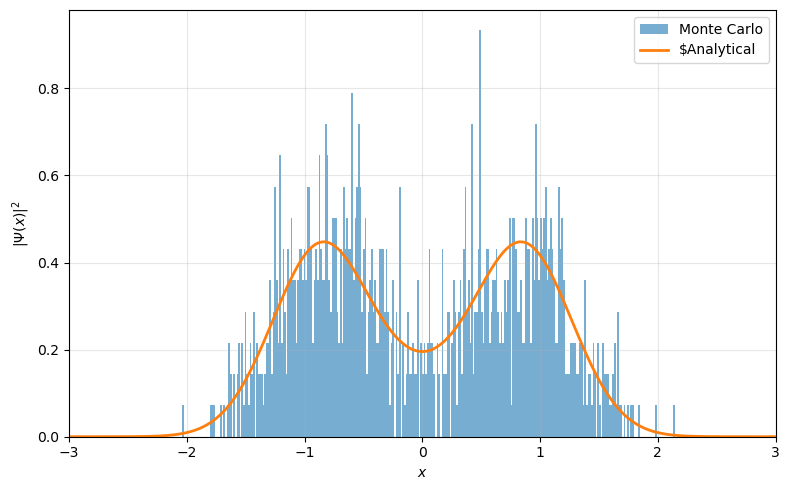

In [227]:
pos = np.loadtxt("../Es08/Output/position.dat")
mu_best=-0.860813
sigma_best=0.582034
x = np.linspace(-3, 3, 400)
# Analytical
def psi_trial(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2)) + np.exp(-(x+mu)**2/(2*sigma**2))
p_var=psi_trial(x, mu_best, sigma_best)**2
p_var/=np.trapz(p_var, x)   # normalization

plt.figure(figsize=(8,5))
plt.hist(pos,bins=300,density=True,alpha=0.6,label='Monte Carlo')
plt.plot(x,p_var,lw=2,label=r'$Analytical')
plt.xlabel(r'$x$')
plt.ylabel(r'$|\Psi(x)|^2$')
plt.xlim(-3,3)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()